In [1]:
import zipfile
import os

zip_path = "/content/burn_data_sorted.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted to:", extract_path)
print("📁 Sample files:", os.listdir(extract_path)[:3])

✅ Extracted to: /content
📁 Sample files: ['.config', 'drive', 'burn_data_sorted']


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import pickle

In [3]:
csv_path = "/content/burn_dataset.csv"

df = pd.read_csv(csv_path)
print("✅ Final image count:", len(df))
df.head()

✅ Final image count: 1221


,image_path,label,label_name
0,/content/burn_data_sorted/First-degree/img298.jpg,0,First-degree
1,/content/burn_data_sorted/Second-degree/img670...,1,Second-degree
2,/content/burn_data_sorted/Second-degree/img382...,1,Second-degree
3,/content/burn_data_sorted/First-degree/img1195...,0,First-degree
4,/content/burn_data_sorted/First-degree/img1379...,0,First-degree


In [ ]:
import os

# Remove rows where image files are missing
df = df[df["image_path"].apply(os.path.exists)].reset_index(drop=True)

print(" Cleaned final image count:", len(df))
print(df.head())

✅ Cleaned final image count: 1215
                                          image_path  label     label_name
0  /content/burn_data_sorted/First-degree/img298.jpg      0   First-degree
1  /content/burn_data_sorted/Second-degree/img670...      1  Second-degree
2  /content/burn_data_sorted/Second-degree/img382...      1  Second-degree
3  /content/burn_data_sorted/First-degree/img1195...      0   First-degree
4  /content/burn_data_sorted/First-degree/img1379...      0   First-degree


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
# created training & validation generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="image_path",
    y_col="label_name",
    target_size=IMG_SIZE, # resize
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    validate_filenames=False
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="image_path",
    y_col="label_name",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
    validate_filenames=False
)

Found 972 non-validated image filenames belonging to 3 classes.
Found 243 non-validated image filenames belonging to 3 classes.


In [ ]:
# load model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=output)

# Freeze base layers to retain features, train only the custom top layers added
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4392 - loss: 1.1601 - val_accuracy: 0.5885 - val_loss: 0.8946
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6103 - loss: 0.7992 - val_accuracy: 0.5967 - val_loss: 0.8240
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6735 - loss: 0.7002 - val_accuracy: 0.6379 - val_loss: 0.8156
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7005 - loss: 0.6528 - val_accuracy: 0.6255 - val_loss: 0.8042
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7336 - loss: 0.6034 - val_accuracy: 0.6543 - val_loss: 0.7911
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7807 - loss: 0.5502 - val_accuracy: 0.6379 - val_loss: 0.7849
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7797 - loss: 0.5282 - val_accuracy: 0.6502 - val_loss: 0.7794
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8033 - loss: 0.4805 - val_accuracy: 0.6461 - val_loss:

In [12]:
model.save("/content/dermaiq_trained_model.h5")
print("Model saved at /content/dermaiq_trained_model.h5")

Model saved at /content/dermaiq_trained_model.h5


In [13]:
with open("/content/burn_model_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("Training history saved as burn_model_history.pkl")

Training history saved as burn_model_history.pkl


In [15]:
# Get true and predicted labels
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
np.save("/content/confusion_matrix.npy", cm)

print("Confusion matrix saved as confusion_matrix.npy")

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
Confusion matrix saved as confusion_matrix.npy


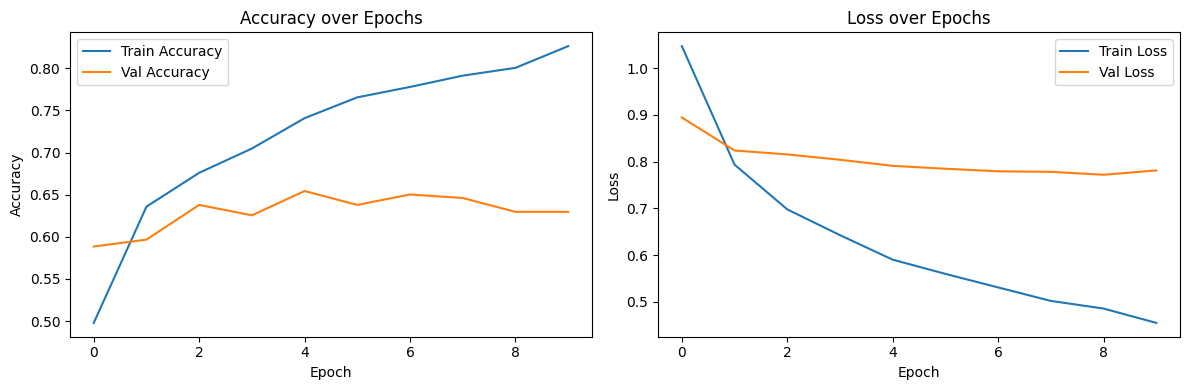

In [16]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()